# Supervised Classification for Cricket match outcomes

This project models whether the **team batting second wins** in an ODI match, using performance features from the **first innings** and the **first 10 overs of the second innings**. In this analysis, we focus on the Support Vector Machine (SVM) classifier — a method that finds the optimal separating hyperplane between classes. The emphasis of this analysis is not predictive accuracy, but a deeper understanding of how and why the SVM works, and how its parameters affect its performance. We have done limited feature engineering as a result of this focus, and hence I think a better accuracy could be achieved if more time had been spent on that.

SVM is an interesting method to focus on, as we can compare how the different choices of kernel function can affect performance. First we introduce the SVM from a mathematical viewpoint, then we implement it and compare different kernels, and finally we try to improve the accuracy of the model.





# Mathematical Formulation: Support Vector Machines and Kernel Methods

The following section is based on the sci-kit learn documentation on SVMs [here](https://scikit-learn.org/stable/modules/svm.html#svm-kernels), and the book *Elements of Statistical Learning* by Hastie, Tibshirani and Friedman (2009).

## 1. Primal Optimization Problem

For a binary classification problem with training data $(\mathbf{x}_i, y_i)$, where $\mathbf{x}_i \in \mathbb{R}^p$ and $y_i \in \{-1, +1\}$, the goal is to find $\mathbf{w} \in \mathbb{R}^p $ and $b \in \mathbb{R}$ such that the decision function $sign(\mathbf{w}^T \mathbf{x}_i + b)$ is correct for most samples. The soft-margin Support Vector Machine (SVM) seeks a hyperplane that maximizes the margin (perpendicular distance between decision boundary and closest datapoints from each class) while allowing some misclassifications. This is formulated as:

$$
\begin{aligned}
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \quad & \frac{1}{2}\|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i \\
\text{s.t.} \quad & y_i(\mathbf{w}^\top \mathbf{x}_i + b) \ge 1 - \xi_i, \quad \xi_i \ge 0, \quad i = 1, \dots, n
\end{aligned}
$$

The term $\frac{1}{2}\|\mathbf{w}\|^2$ encourages a large margin, while the penalty term $C\sum_i \xi_i$ penalizes margin violations. The constant $C>0$ controls the trade-off between maximizing the margin and minimizing training errors.

---

## 2. Dual Problem Formulation

Introducing Lagrange multipliers $\alpha_i \ge 0$ and $\mu_i \ge 0$, we construct the Lagrangian:

$$
\mathcal{L}(\mathbf{w}, b, \boldsymbol{\xi}, \boldsymbol{\alpha}, \boldsymbol{\mu}) =
\frac{1}{2}\|\mathbf{w}\|^2 + C\sum_i \xi_i
- \sum_i \alpha_i [y_i(\mathbf{w}^\top \mathbf{x}_i + b) - 1 + \xi_i]
- \sum_i \mu_i \xi_i
$$

Setting the partial derivatives with respect to the primal variables to zero gives:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{w}} = 0 \Rightarrow \mathbf{w} = \sum_i \alpha_i y_i \mathbf{x}_i, \quad
\frac{\partial \mathcal{L}}{\partial b} = 0 \Rightarrow \sum_i \alpha_i y_i = 0, \quad
\frac{\partial \mathcal{L}}{\partial \xi_i} = 0 \Rightarrow \alpha_i + \mu_i = C
$$

Substituting back yields the **dual optimization problem**:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_i \alpha_i - \frac{1}{2}\sum_i \sum_j \alpha_i \alpha_j y_i y_j (\mathbf{x}_i^\top \mathbf{x}_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \sum_i \alpha_i y_i = 0
\end{aligned}
$$

---

## 3. Kernel Trick and Nonlinear Mapping

The dual form depends only on inner products $\mathbf{x}_i^\top \mathbf{x}_j$. By replacing these with a kernel function

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \phi(\mathbf{x}_i)^\top \phi(\mathbf{x}_j),
$$

we implicitly map the inputs into a higher-dimensional feature space via $\phi(\cdot)$ without explicitly computing the transformation. The dual problem becomes:

$$
\begin{aligned}
\max_{\boldsymbol{\alpha}} \quad & \sum_i \alpha_i - \frac{1}{2}\sum_i \sum_j \alpha_i \alpha_j y_i y_j K(\mathbf{x}_i, \mathbf{x}_j) \\
\text{s.t.} \quad & 0 \le \alpha_i \le C, \quad \sum_i \alpha_i y_i = 0
\end{aligned}
$$

The resulting decision function is:

$$
f(\mathbf{x}) = \sum_i \alpha_i y_i K(\mathbf{x}_i, \mathbf{x}) + b,
$$

and the final prediction is $\hat{y} = \text{sign}(f(\mathbf{x}))$. Only observations with $\alpha_i > 0$ (the *support vectors*) influence the boundary.

---

## 4. Common Kernel Functions

Different choices of the kernel function $K(\cdot, \cdot)$ allow the SVM to learn complex, non-linear relationships.

| **Kernel** | **Definition** | **Effect** |
|-------------|----------------|-------------|
| Linear | $K(x, x') = x^\top x'$ | Linear separation; equivalent to no feature mapping. |
| Polynomial | $K(x, x') = (\gamma x^\top x' + r)^d$ | Models interactions up to degree $d$. |
| RBF (Gaussian) | $K(x, x') = \exp(-\gamma \|x - x'\|^2)$ | Infinite-dimensional mapping; smooth non-linear boundaries. |
| Sigmoid (Tanh) | $K(x, x') = \tanh(\gamma x^\top x' + r)$ | Similar to neural network activations; non-linear boundaries. |

---

## 5. Mathematical Properties of Kernels

### (a) Linear Kernel
This is the simplest case where $K(x, x') = x^\top x'$.  
The decision boundary is a hyperplane:

$$
f(x) = \mathbf{w}^\top x + b
$$

and the margin width is $\frac{2}{\|\mathbf{w}\|}$.

### (b) Polynomial Kernel
The polynomial kernel,

$$
K(x, x') = (\gamma x^\top x' + r)^d,
$$

expands the feature space to include all cross-terms up to degree $d$.  
For instance, with $d=2$, quadratic interactions between features (e.g., run rate × wickets) are captured.  
Larger $d$ increases model complexity but can cause overfitting.

### (c) Radial Basis Function (RBF) Kernel
Defined as:

$$
K(x, x') = \exp(-\gamma \|x - x'\|^2),
$$

this kernel measures local similarity, producing smooth, non-linear decision boundaries.  
The parameter $\gamma$ controls the influence radius of support vectors:

$$
\text{Small } \gamma \Rightarrow \text{broader, smoother decision boundary}; \quad
\text{Large } \gamma \Rightarrow \text{narrower, more complex boundary.}
$$

### (d) Sigmoid Kernel
Inspired by neural networks:

$$
K(x, x') = \tanh(\gamma x^\top x' + r).
$$

It resembles the activation function of a neuron.  
However, for the kernel to be positive semi-definite (and ensure convexity), parameters must satisfy certain conditions, typically $\gamma > 0$ and $r < 0$.  
While less commonly used, the sigmoid kernel offers an interesting bridge between SVMs and neural network theory.

---

## 6. Comparison to Logistic Regression

The SVM minimizes the *hinge loss*:

$$
L(y, f(x)) = \max(0, 1 - y f(x)),
$$

which penalizes only points that lie within or across the margin.  
In contrast, logistic regression minimizes the log-loss:

$$
L(y, f(x)) = \log(1 + e^{-y f(x)}).
$$

Both models regularize $\|\mathbf{w}\|^2$, but SVMs focus on maximizing the margin, leading to sparse solutions (only support vectors matter), while logistic regression considers all points.

---

## 7. Implementation on Cricket ODI Dataset

Now we will implement the Kernel trick for SVM in the context of the Cricket ODI dataset. We will adjust the dataset slightly, so that we have the desired prediction problem of predicting match outcome based on the first innings and first 10 overs of the second innings. To do this we use pandas to manipulate our data, then fit the models using sci-kit learn. Once fitted, we can compare the performance of the different kernels on this dataset using ROC AUC and accuracy metrics.

In [2]:
import pandas as pd

file_path = "odi_bbb.csv"

try:
    df = pd.read_csv(
        file_path,
        encoding="utf-8",     # handle common encoding issues
        na_values=["", "NA"], # treat empty strings or "NA" as missing
        dtype=str             # (optional) read all as strings first if unsure
    )
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
except pd.errors.EmptyDataError:
    print("Error: The file is empty.")
except pd.errors.ParserError:
    print("Error: Problem parsing the CSV.")



In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Make total runs column
df["total_runs"] = df["runs_off_bat"] + df["extras"]

numeric_cols = [
    "ball", "runs_off_bat", "extras", "total_runs"
]

# Ensure all of the numeric features are numeric - some were strings in my testing.
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")


# Get first and second innings
innings1 = df[df["innings"] == '1']
innings2 = df[df["innings"] == '2']

# --- FIRST INNINGS FEATURES ---

# Here I added boundaries as a feature as it was deemed useful in the EDA in Assessment 0
first_innings = innings1.groupby(["match_id", "batting_team"]).agg(
    runs_1=("total_runs", "sum"),
    wickets_1=("wicket_type", "count"),
    boundaries_1=("runs_off_bat", lambda x: ((x == 4) | (x == 6)).sum()),
    balls_faced_1=("ball", "count")  # total deliveries
).reset_index()

first_innings["overs_1"] = first_innings["balls_faced_1"] / 6
first_innings["run_rate_1"] = first_innings["runs_1"] / first_innings["overs_1"]


# --- SECOND INNINGS FEATURES (first 10 overs only) ---
innings2_10 = innings2[innings2["ball"] <= 10]

second_innings = innings2_10.groupby(["match_id", "batting_team"]).agg(
    runs_2_10=("total_runs", "sum"),
    wickets_2_10=("wicket_type", "count"),
    boundaries_2_10=("runs_off_bat", lambda x: ((x == 4) | (x == 6)).sum()),
    balls_faced_2_10=("ball", "count")
).reset_index()

second_innings["overs_2_10"] = second_innings["balls_faced_2_10"] / 6
second_innings["run_rate_2_10"] = second_innings["runs_2_10"] / second_innings["overs_2_10"]


# --- MERGE ---
matches = pd.merge(first_innings, second_innings, on="match_id", suffixes=("_1", "_2"))

# Add metadata (winner etc.)
meta_cols = ["match_id", "team1", "team2", "winner", "venue.x", "season"]
meta = df[meta_cols].drop_duplicates("match_id")

matches = matches.merge(meta, on="match_id")

# --- TARGET VARIABLE ---
matches["team2_win"] = (matches["winner"] == matches["team2"]).astype(int)



In [16]:
# --- ENCODING ---
# Here we one-hot-encode the qualitative varibales.
cat_cols = ["batting_team_1", "batting_team_2", "venue.x", "season"]
matches_encoded = pd.get_dummies(matches, columns=cat_cols, drop_first=True)

# --- FEATURES AND TARGET ---
X = matches_encoded.drop(columns=["match_id", "winner", "team1", "team2", "team2_win"])
y = matches_encoded["team2_win"]

# --- TRAIN/TEST SPLIT ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)



Now that the data has been modified and split into a training and testing set, we can train the SVM model and compare which of the kernels work the best. SVM is sensitive to scale of features so we standardize these using StandardScaler(). Since we have a binary classification problem, we will use SVC from sci-kit learn with different kernel options. SVM does handle multi-class problems, but here we focus on binary classification for our match outcome problem. The Sci-jit learn documentation explicitly states that the RBF kernel needs to have its gamma and C parameters tuned for good performance, so we use grid search cross-validation to find the best parameters for each kernel. 

In [12]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

# X = features, y = 1 if chasing team wins else 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define SVM pipeline
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])

svm_model.fit(X_train, y_train)
y_pred = svm_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.66      0.76      0.71       194
           1       0.61      0.48      0.54       149

    accuracy                           0.64       343
   macro avg       0.63      0.62      0.62       343
weighted avg       0.64      0.64      0.63       343

[[148  46]
 [ 77  72]]


In [13]:
param_grid = {
    'svm__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'svm__C': [0.01, 0.1, 1, 10],
    'svm__gamma': ['scale', 0.1, 1]
}

grid = GridSearchCV(svm_model, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-val score:", grid.best_score_)


Best parameters: {'svm__C': 0.1, 'svm__gamma': 0.1, 'svm__kernel': 'sigmoid'}
Best cross-val score: 0.675


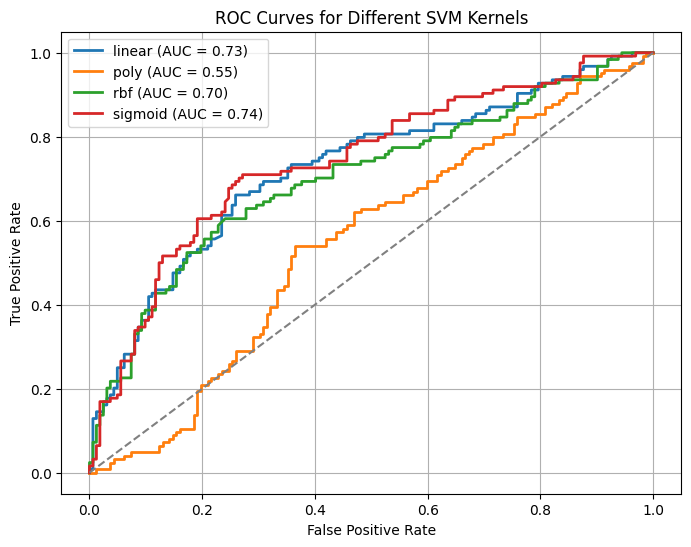

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

kernels = ['linear', 'poly', 'rbf', 'sigmoid']
roc_results = {}

for kernel in kernels:
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(kernel=kernel, probability=True, C=0.1, gamma='scale', random_state=42))
    ])
    model.fit(X_train, y_train)
    y_score = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_results[kernel] = (fpr, tpr, roc_auc)

# Plot
plt.figure(figsize=(8,6))
for kernel, (fpr, tpr, roc_auc) in roc_results.items():
    plt.plot(fpr, tpr, lw=2, label=f'{kernel} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], color='grey', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Different SVM Kernels')
plt.legend()
plt.grid(True)
plt.show()


### 8. PCA and t-SNE Visualizations

To try and understand why the linear kernel outperforms the non-linear kernels on this dataset, we can visualize the data using PCA and t-SNE to see if the classes are linearly separable in lower dimensions. We will plot the results of the first two components from PCA and the two dimensions from t-SNE, coloring the points by their class labels.

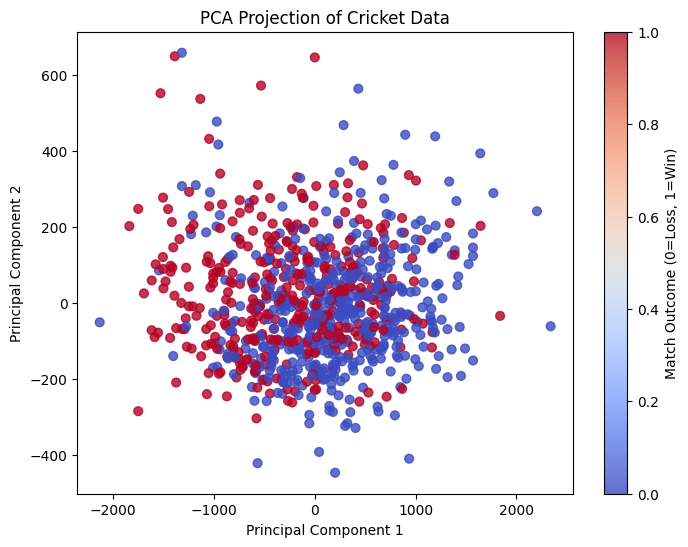

In [89]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train, cmap='coolwarm', s=40, alpha=0.8)
plt.title("PCA Projection of Cricket Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Match Outcome (0=Loss, 1=Win)")
plt.show()



From this plot we can see that the red and blue points are highly overlapping - and there is no clear non-linear boundary that can separate them. This suggests that the data is not easily separable in lower dimensions, which may explain why the non-linear kernels do not perform better than the linear kernel on this dataset. You can see that a tilted linear boundary could separate some of the points, which is consistent with the linear kernel performing best.

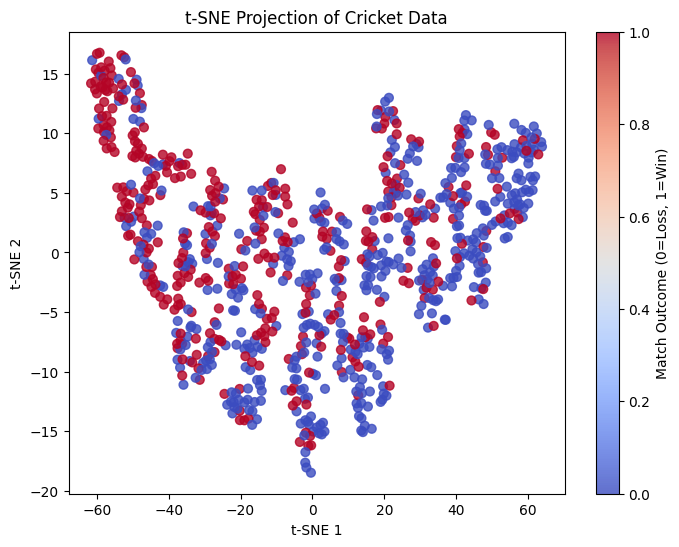

In [90]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_train)

plt.figure(figsize=(8,6))
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y_train, cmap='coolwarm', s=40, alpha=0.8)
plt.title("t-SNE Projection of Cricket Data")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar(label="Match Outcome (0=Loss, 1=Win)")
plt.show()


The t-SNE plot shows the data is clearly not random noise, there is structure present. The red and blue points are intermixed across the plot, and there are no clear non linear boundaries that can separate the classes. This again suggests that the data is not easily separable in lower dimensions, which may explain why the non-linear kernels do not perform better than the linear kernel on this dataset. Whilst the data does form a U-shape, the classes are not easiluy separable along this structure.